In [2]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
sys.path.append('./../../RoboPoint/')

from robopoint_utils import load_model, get_coordinates, generate_prompt, do_inference_with_logits, calculate_probs_per_coordinate
from utils import extract_all, plot_scatter, calculate_euclidian_distance, calculate_normalized_euclidian_distance, visualize_points_on_image, close_all_images, cluster_data, calculate_spread, show_cluster, calculate_roc_curve, plot_roc_curve, find_best_threshold
from PIL import Image

2025-03-14 09:53:15.664999: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 09:53:15.704553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 09:53:15.704582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 09:53:15.704604: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 09:53:15.712582: I tensorflow/core/platform/cpu_feature_g

In [3]:
model_name = "wentao-yuan/robopoint-v1-vicuna-v1.5-13b"
model, processor, tokenizer = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint at wentao-yuan/robopoint-v1-vicuna-v1.5-13b were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder

In [4]:
import numpy as np

def run_spread_and_prob_experiment(prompts, temperatures, runs_per_instance, ignoreCoordinateDecimalPlaces, experiment_path = "../data/first_experiments"):
    tasks, images, ground_truths, object_list = extract_all(experiment_path)

    list_of_distances = []
    list_of_spreads = []
    list_of_probs = []
    labels = []
    for i in range(len(tasks)):
        print(f"Task: {i + 1}")
        print(tasks[i])
    
        image_path = images[i]
        task = tasks[i]
        objects = object_list[i]
        groundtruths = ground_truths[i]

        with Image.open(image_path) as image:
            width, height = image.size
            for object, groundtruth in zip(objects, groundtruths):
                coordinates_per_task = []
                probs = []
                distances = []
                image_labels = []

                for prompt_start in prompts:
                    prompt = generate_prompt(object, prompt_start)

                    for temperature in temperatures:
                    
                        for j in range(runs_per_instance):
                            generated_text, outputs = do_inference_with_logits(image, prompt, model, processor, tokenizer, temperature)
                            
                            coordinates = get_coordinates(generated_text, width, height)
                            if len(coordinates) == 0:
                                continue

                            first_prob = calculate_probs_per_coordinate(outputs, ignoreCoordinateDecimalPlaces)[0].item()
                            distance = calculate_normalized_euclidian_distance(coordinates[0], groundtruth, width, height)
                            
                            image_labels.append(f"{prompt_start}({temperature})")
                            probs.append(first_prob)
                            distances.append(distance)
                            coordinates_per_task.append(coordinates[0])
                
                label = task + " (" + object + ")"
                labels.append(label)
                list_of_distances.append(np.mean(distances))
                list_of_probs.append(np.mean(probs))
                list_of_spreads.append(calculate_spread(coordinates_per_task, width, height))
                    
    return labels, list_of_distances, list_of_spreads, list_of_probs

In [5]:
from matplotlib import pyplot as plt

def plot_scatter_report(labels, list_of_x, list_of_y, filename, title="Scatterplot", x_label="Distance to Groundtruth", y_label="Probabilities"):
    for label, x, y in zip(labels, list_of_x, list_of_y):
        plt.scatter(x, y, marker='o', label=label)
    
    # Adding labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc="lower right")
    
    # Show the plot
    plt.savefig(filename)
    plt.show()
    plt.close()

def plot_roc_curve_report(fpr, tpr, roc_auc, filename, title = "Receiver Operating Characteristic (ROC) Curve for Distance-Based Classification"):
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Random classifier line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

In [7]:
import numpy as np

PROMPTS = [
    "Locate several points within the space of the ",
    "Locate several points within the area of the ",
    "Identify multiple points within the space of the ",
    "Identify several points within the area of the ",
    "Identify several spots within the space of the "
]

TEMPERATURES = [
    0.6
]


labels, list_of_distances, list_of_spreads, list_of_probs = run_spread_and_prob_experiment(
    prompts = PROMPTS,
    temperatures = TEMPERATURES,
    runs_per_instance = 6,
    ignoreCoordinateDecimalPlaces = True,
    experiment_path = "../data/certain_experiments"
)

np.savez(
    'results/robopoint-temp06-5prompts-6runs-certain.npz', 
    labels=labels,
    distances=list_of_distances, 
    spreads=list_of_spreads,
    probs=list_of_probs,
)

Task: 1
pull the oven tray
Task: 2
take cucumber out of cup
Task: 3
move the fruit from the left stove to the sink
Task: 4
open low fridge
Task: 5
open the drawer
Task: 6
Move the can from the top left of the burner to the bottom left of the burner
Task: 7
Place the pot to the right of the blue fork.
Task: 8
move the pot from the right to the left stove
Task: 9
put potato in pot or pan
Task: 10
take cucumber out of cup
Task: 11
move the banana from the left stove to the sink
Task: 12
pick up the toast and put it to the sink
Task: 13
close the microwave
Task: 14
push the toaster lever
Task: 15
take the broccoli and put it between the two right burners
Task: 16
move the pot from the left to the right stove


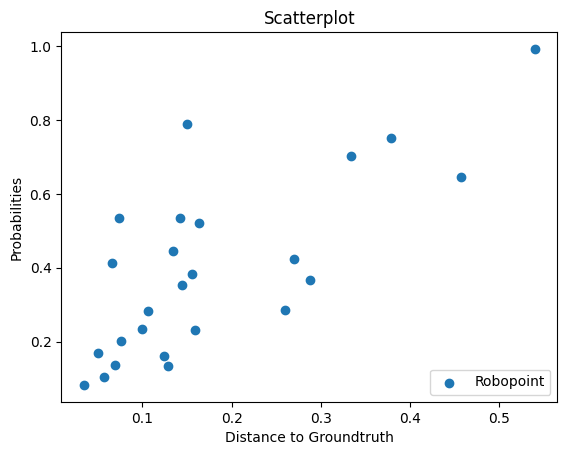

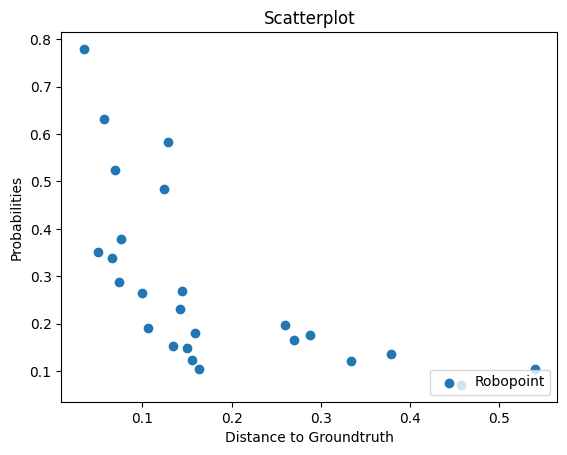

In [9]:
import itertools

data_filename = 'results/robopoint-temp06-5prompts-6runs-certain.npz'
plot_filename = 'results/robopoint-temp06-5prompts-6runs-certain.png'

loaded = np.load(data_filename)
distances_robopoint = loaded['distances']
spreads_robopoint = loaded['spreads']
probs_robopoint = loaded['probs']

plot_scatter_report(["Robopoint"], [distances_robopoint], [spreads_robopoint], plot_filename)
plot_scatter_report(["Robopoint"], [distances_robopoint], [probs_robopoint], plot_filename)

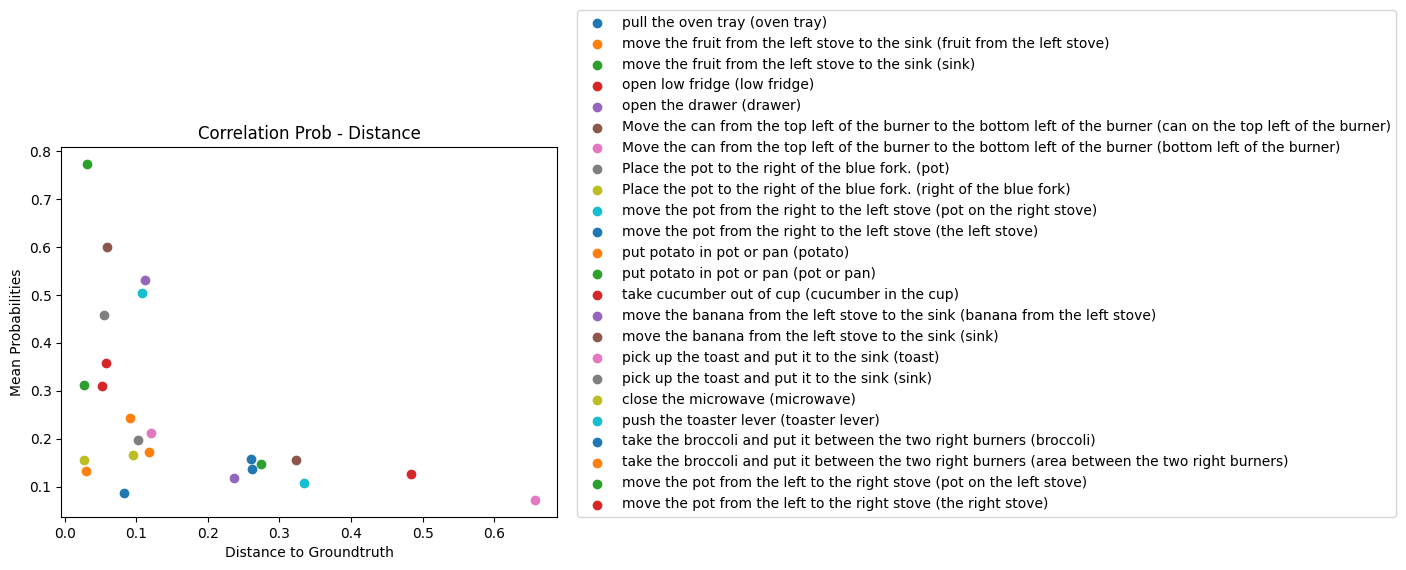

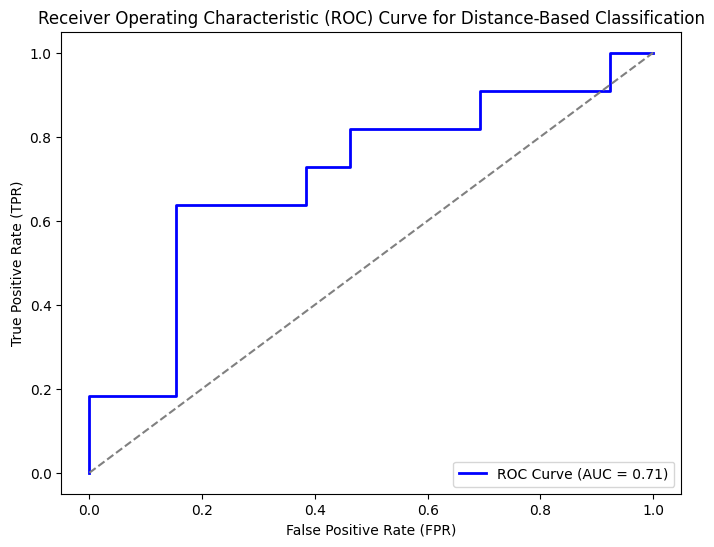

Best Threshold: 0.24412955865263938 with tpr = 0.6363636363636364 and fpr = 0.15384615384615385


In [10]:
plot_scatter(labels, list_of_probs, list_of_distances, "Correlation Prob - Distance", "Distance to Groundtruth", "Mean Probabilities")

scores = list_of_probs
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(list_of_distances, 0.1, scores)
plot_roc_curve(fpr, tpr, roc_auc)

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
print(f"Best Threshold: { thresholds[best_idx] } with tpr = { tpr[best_idx] } and fpr = { fpr[best_idx] }")

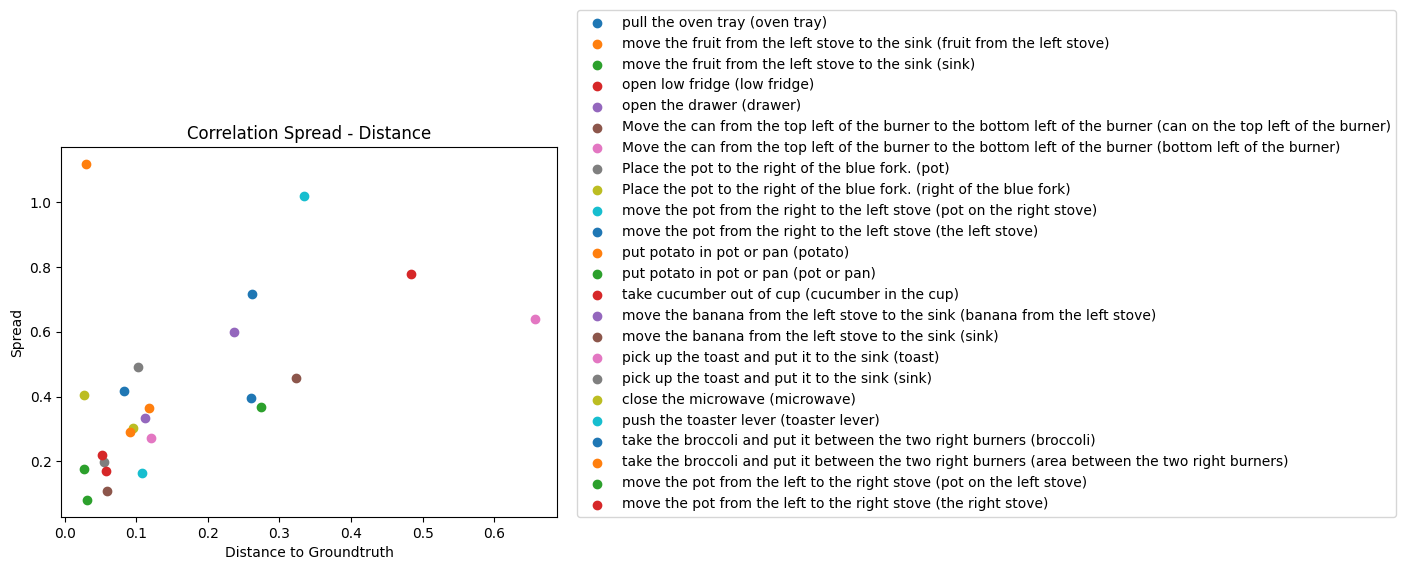

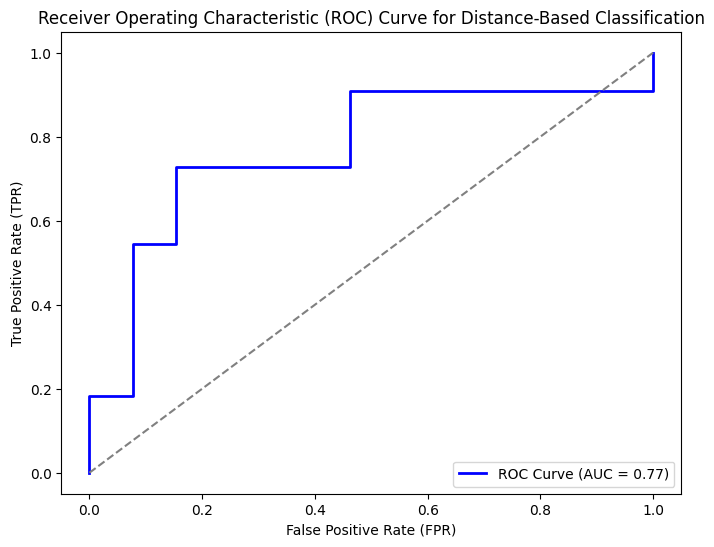

Best Threshold: 0.30313215913653524 with tpr = 0.7272727272727273 and fpr = 0.15384615384615385


In [12]:
plot_scatter(labels, list_of_spreads, list_of_distances, "Correlation Spread - Distance", "Distance to Groundtruth", "Spread")

scores = 1 - np.array(list_of_spreads)
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(list_of_distances, 0.1, scores)
plot_roc_curve(fpr, tpr, roc_auc)

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
print(f"Best Threshold: { 1 - thresholds[best_idx] } with tpr = { tpr[best_idx] } and fpr = { fpr[best_idx] }")

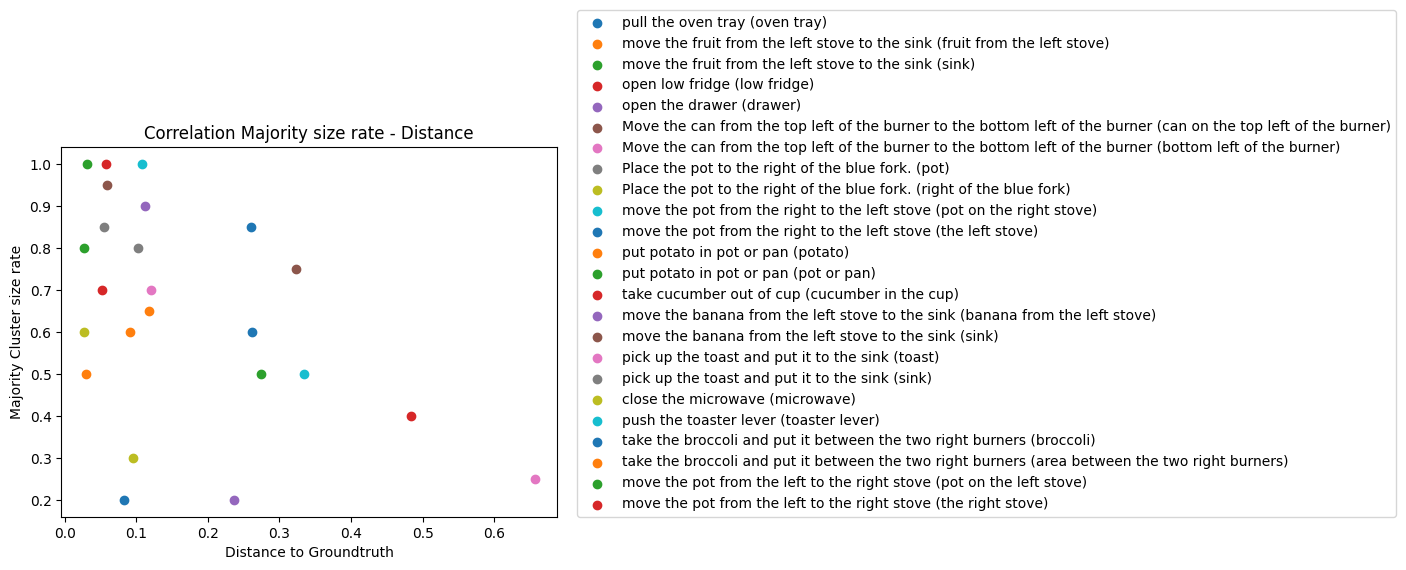

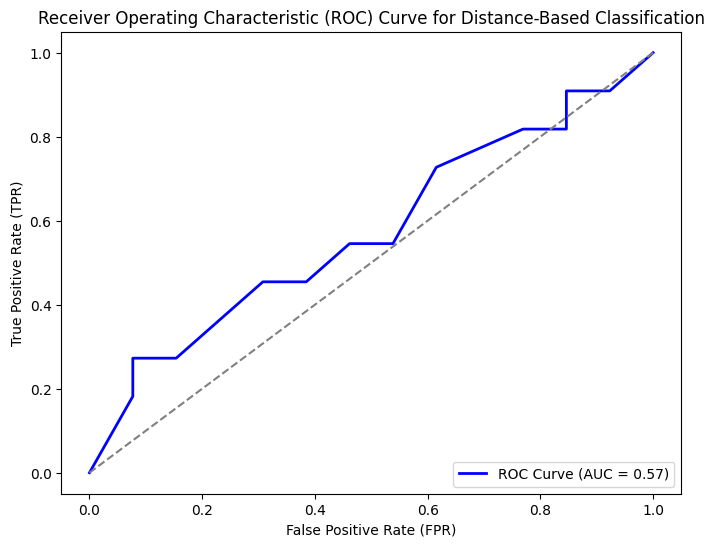

Best Threshold: 0.95 with tpr = 0.2727272727272727 and fpr = 0.07692307692307693


In [13]:
plot_scatter(labels, list_of_majority_size_rate, list_of_distances, "Correlation Majority size rate - Distance", "Distance to Groundtruth", "Majority Cluster size rate")

scores = list_of_majority_size_rate
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(list_of_distances, 0.1, scores)
plot_roc_curve(fpr, tpr, roc_auc)

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
print(f"Best Threshold: { thresholds[best_idx] } with tpr = { tpr[best_idx] } and fpr = { fpr[best_idx] }")

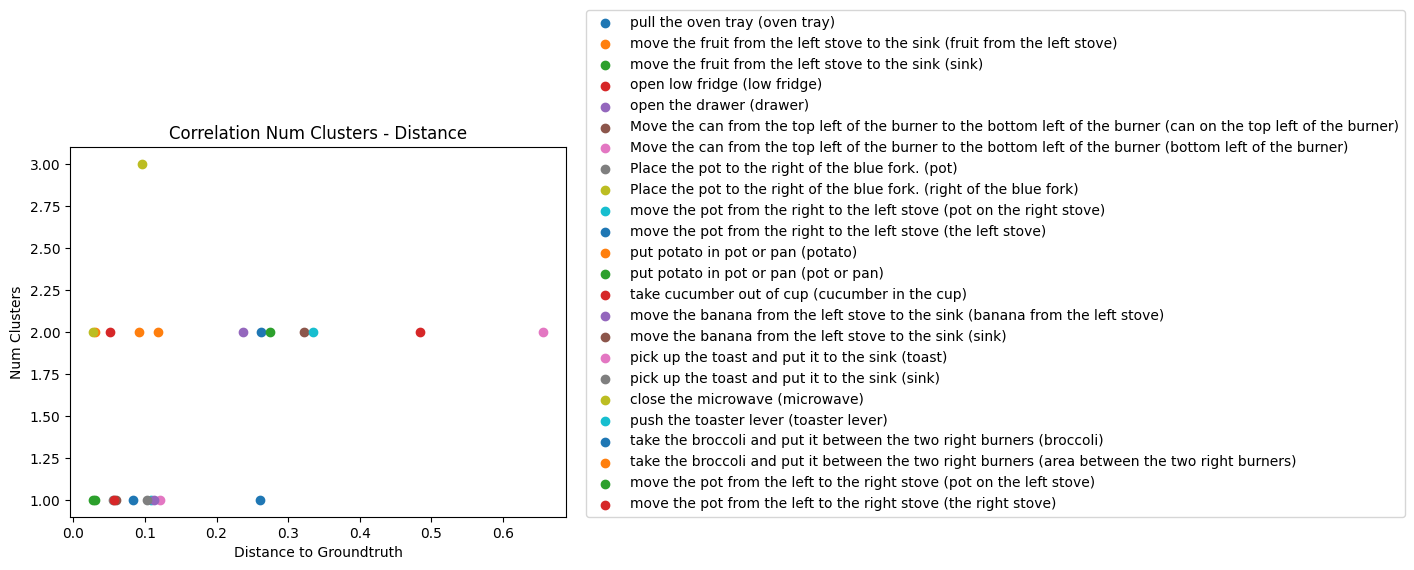

ValueError: Found input variables with inconsistent numbers of samples: [24, 1]

In [17]:
from sklearn import preprocessing
plot_scatter(labels, list_of_cluster_number, list_of_distances, "Correlation Num Clusters - Distance", "Distance to Groundtruth", "Num Clusters")

scores = preprocessing.normalize([list_of_cluster_number])
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(list_of_distances, 0.1, scores)
plot_roc_curve(fpr, tpr, roc_auc)

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
print(f"Best Threshold: { thresholds[best_idx] } with tpr = { tpr[best_idx] } and fpr = { fpr[best_idx] }")